In [118]:
# General assumption: weather data forecast is given (and accurate)
import pandas as pd
import numpy as np
import tensorflow as tf 

dataset = pd.read_csv('preprocessed/daily_data.csv')
dataset.columns

Index(['day', 'temp_min', 'temp_max', 'feels_like', 'pressure', 'humidity',
       'wind_speed', 'wind_deg', 'is_offday', 'demand', 'rrp'],
      dtype='object')

In [123]:
def create_dataset(df, window_size, forecast_size, batch_size, is_test=False):

    shuffle_buffer_size = len(df)
    # Total size of window is given by the number of steps to be considered
    # before prediction time + steps that we want to forecast
    total_size = window_size + forecast_size
    #print(df.values[:,1:])
    temp = np.asarray(df.values[:,1:]).astype(np.float32)
    data = tf.data.Dataset.from_tensor_slices(temp)

    # Selecting windows
    data = data.window(total_size, shift=forecast_size, drop_remainder=True)
    data = data.flat_map(lambda k: k.batch(total_size))

    # Shuffling data
    if not is_test:
        data = data.shuffle(shuffle_buffer_size, seed=42)
    
    # Separate past and feature
    data = data.map(lambda k: ((k[:window_size], k[window_size:, :8]), k[window_size:, 8])) 
    return data.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

In [142]:
# Times at which to split train/validation and validation/test
train_split = 1325
val_test_split = 150

window_len = 7 # How much data from the past should we need for a forecast? (days)
forecast_len = 7 # How far ahead do we want to generate forecasts? (days)

# Splitting dataset into train/val/test
training_data = dataset.iloc[:train_split]
validation_data = dataset.iloc[train_split:train_split+val_test_split]
test_data = dataset.iloc[train_split+val_test_split:]

#normalize based on training
maxs = {}
for col in training_data.columns[1:]:
    training_data = training_data.copy()
    validation_data = validation_data.copy()
    test_data = test_data.copy()
    
    max_data = training_data[col].max()
    maxs[col] = max_data
    training_data[col] = training_data[col] / max_data
    validation_data[col] = validation_data[col] / max_data
    test_data[col] = test_data[col] / max_data

In [143]:
maxs

{'temp_min': 27.06083333333333,
 'temp_max': 33.142916666666665,
 'feels_like': 30.93166666666667,
 'pressure': 1036.9583333333333,
 'humidity': 99.54166666666669,
 'wind_speed': 7.9629166666666675,
 'wind_deg': 356.25,
 'is_offday': 1,
 'demand': 330141.19,
 'rrp': 43417.4}

In [144]:
# Now we get training, validation, and test as tf.data.Dataset objects
batch_size = 32
training_windowed = create_dataset(training_data, window_len, forecast_len, batch_size)
validation_windowed = create_dataset(validation_data, window_len, forecast_len, batch_size)
test_windowed = create_dataset(test_data, window_len, forecast_len, batch_size=1, is_test=True)

In [145]:
test_data

,day,temp_min,temp_max,feels_like,pressure,humidity,wind_speed,wind_deg,is_offday,demand,rrp
1475,2019/01/15,0.816478,0.903939,0.923204,0.972275,0.717036,0.232170,0.479883,0.0,0.923824,0.230942
1476,2019/01/16,0.738875,0.785374,0.776106,0.973681,0.751779,0.291612,0.557310,0.0,0.829777,0.194973
1477,2019/01/17,0.859930,0.874835,0.894593,0.971230,0.655923,0.205850,0.506433,0.0,0.879693,0.187511
1478,2019/01/18,0.773412,0.758345,0.777305,0.972797,0.734617,0.294804,0.541988,0.0,0.817215,0.150605
1479,2019/01/19,0.614664,0.678853,0.583625,0.982601,0.616576,0.361572,0.611696,1.0,0.616054,0.088891
...,...,...,...,...,...,...,...,...,...,...,...
2096,2020/09/27,0.282065,0.359592,0.183051,0.987905,0.725827,0.548899,0.570175,1.0,0.616121,0.058659
2097,2020/09/28,0.268053,0.360547,0.222278,0.990437,0.747593,0.301606,0.525380,0.0,0.694558,0.062293
2098,2020/09/29,0.386105,0.430082,0.265262,0.984570,0.667225,0.578201,0.616374,0.0,0.678961,0.044987
2099,2020/09/30,0.472994,0.490566,0.348161,0.974388,0.722512,0.714311,0.866807,0.0,0.688313,0.041145


In [146]:
latent_dim = 100
n_total_features = 10 # 10
n_deterministic_features = 8 # 8

# First branch of the net is an lstm which finds an embedding for the past
past_inputs = tf.keras.Input(
    shape=(window_len, n_total_features), name='past_inputs')
# Encoding the past
encoder = tf.keras.layers.LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(past_inputs)

future_inputs = tf.keras.Input(
    shape=(forecast_len, n_deterministic_features), name='future_inputs')
# Combining future inputs with recurrent branch output
decoder_lstm = tf.keras.layers.LSTM(latent_dim, return_sequences=True)
x = decoder_lstm(future_inputs,
                 initial_state=[state_h, state_c])

x = tf.keras.layers.Dense(64, activation='tanh')(x)
x = tf.keras.layers.Dense(32, activation='tanh')(x)
output = tf.keras.layers.Dense(1, activation='relu')(x)

model = tf.keras.models.Model(
    inputs=[past_inputs, future_inputs], outputs=output)

optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.Huber()
model.compile(loss=loss, optimizer=optimizer, metrics=["mae"])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=50)

In [147]:
history = model.fit(training_windowed, epochs=200,
                    validation_data=validation_windowed, callbacks=[callback])

Epoch 1/200
6/6 [==============================] - 5s 842ms/step - loss: 0.0701 - mae: 0.3178 - val_loss: 0.0410 - val_mae: 0.2716
Epoch 2/200
6/6 [==============================] - 0s 51ms/step - loss: 0.0149 - mae: 0.1402 - val_loss: 0.0125 - val_mae: 0.1360
Epoch 3/200
6/6 [==============================] - 0s 56ms/step - loss: 0.0141 - mae: 0.1442 - val_loss: 0.0031 - val_mae: 0.0620
Epoch 4/200
6/6 [==============================] - 0s 56ms/step - loss: 0.0063 - mae: 0.0910 - val_loss: 0.0110 - val_mae: 0.1356
Epoch 5/200
6/6 [==============================] - 0s 50ms/step - loss: 0.0046 - mae: 0.0772 - val_loss: 0.0023 - val_mae: 0.0520
Epoch 6/200
6/6 [==============================] - 0s 56ms/step - loss: 0.0043 - mae: 0.0744 - val_loss: 0.0022 - val_mae: 0.0525
Epoch 7/200
6/6 [==============================] - 0s 59ms/step - loss: 0.0024 - mae: 0.0554 - val_loss: 0.0051 - val_mae: 0.0883
Epoch 8/200
6/6 [==============================] - 0s 53ms/step - loss: 0.0027 - mae: 0.0

6/6 [==============================] - 0s 37ms/step - loss: 0.0011 - mae: 0.0356 - val_loss: 0.0012 - val_mae: 0.0392
Epoch 64/200
6/6 [==============================] - 0s 38ms/step - loss: 0.0011 - mae: 0.0352 - val_loss: 0.0016 - val_mae: 0.0463
Epoch 65/200
6/6 [==============================] - 0s 42ms/step - loss: 0.0010 - mae: 0.0344 - val_loss: 0.0016 - val_mae: 0.0459
Epoch 66/200
6/6 [==============================] - 0s 43ms/step - loss: 0.0010 - mae: 0.0342 - val_loss: 0.0013 - val_mae: 0.0410
Epoch 67/200
6/6 [==============================] - 0s 39ms/step - loss: 9.8405e-04 - mae: 0.0339 - val_loss: 0.0014 - val_mae: 0.0421
Epoch 68/200
6/6 [==============================] - 0s 65ms/step - loss: 0.0010 - mae: 0.0340 - val_loss: 0.0013 - val_mae: 0.0411
Epoch 69/200
6/6 [==============================] - 0s 34ms/step - loss: 0.0011 - mae: 0.0352 - val_loss: 0.0019 - val_mae: 0.0504
Epoch 70/200
6/6 [==============================] - 0s 50ms/step - loss: 9.8702e-04 - mae: 0

6/6 [==============================] - 0s 53ms/step - loss: 5.3925e-04 - mae: 0.0245 - val_loss: 8.0666e-04 - val_mae: 0.0307
Epoch 124/200
6/6 [==============================] - 0s 41ms/step - loss: 5.5197e-04 - mae: 0.0252 - val_loss: 7.1204e-04 - val_mae: 0.0283
Epoch 125/200
6/6 [==============================] - 0s 33ms/step - loss: 5.0889e-04 - mae: 0.0236 - val_loss: 7.1098e-04 - val_mae: 0.0284
Epoch 126/200
6/6 [==============================] - 0s 37ms/step - loss: 4.8851e-04 - mae: 0.0229 - val_loss: 7.7702e-04 - val_mae: 0.0296
Epoch 127/200
6/6 [==============================] - 0s 48ms/step - loss: 4.9639e-04 - mae: 0.0233 - val_loss: 0.0012 - val_mae: 0.0408
Epoch 128/200
6/6 [==============================] - 0s 53ms/step - loss: 5.6116e-04 - mae: 0.0251 - val_loss: 8.7691e-04 - val_mae: 0.0328
Epoch 129/200
6/6 [==============================] - 0s 36ms/step - loss: 5.3937e-04 - mae: 0.0245 - val_loss: 8.1612e-04 - val_mae: 0.0308
Epoch 130/200
6/6 [===================

Epoch 182/200
6/6 [==============================] - 0s 41ms/step - loss: 7.2363e-04 - mae: 0.0302 - val_loss: 5.9237e-04 - val_mae: 0.0269
Epoch 183/200
6/6 [==============================] - 0s 50ms/step - loss: 5.7992e-04 - mae: 0.0260 - val_loss: 6.3487e-04 - val_mae: 0.0282
Epoch 184/200
6/6 [==============================] - 0s 50ms/step - loss: 5.0306e-04 - mae: 0.0244 - val_loss: 6.5287e-04 - val_mae: 0.0282
Epoch 185/200
6/6 [==============================] - 0s 51ms/step - loss: 4.5114e-04 - mae: 0.0223 - val_loss: 5.8424e-04 - val_mae: 0.0264
Epoch 186/200
6/6 [==============================] - 0s 54ms/step - loss: 4.1773e-04 - mae: 0.0215 - val_loss: 8.8504e-04 - val_mae: 0.0325
Epoch 187/200
6/6 [==============================] - 0s 65ms/step - loss: 3.9975e-04 - mae: 0.0208 - val_loss: 7.8676e-04 - val_mae: 0.0308
Epoch 188/200
6/6 [==============================] - 0s 82ms/step - loss: 4.0780e-04 - mae: 0.0209 - val_loss: 8.1839e-04 - val_mae: 0.0317
Epoch 189/200
6/6 [=

In [148]:
model.evaluate(test_windowed)

     88/Unknown - 1s 10ms/step - loss: 9.1538e-04 - mae: 0.0322

[0.0009153818164536046, 0.032168474]

In [149]:
preds=model.predict(test_windowed)*maxs['demand']

In [150]:
preds = np.reshape(preds, -1)[:-10]

In [151]:
golds = test_data['demand']*maxs['demand']
golds = golds.tolist()[window_len:][:len(preds)]
days = test_data['day'].tolist()[window_len:][:len(preds)]

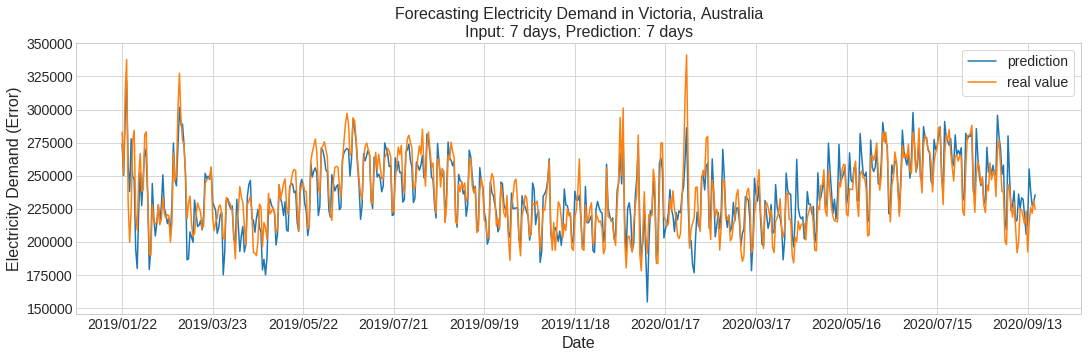

In [152]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

title = f'Forecasting Electricity Demand in Victoria, Australia\nInput: {window_len} days, Prediction: {forecast_len} days'
fig = plt.figure(figsize=(18,5))
ax = plt.axes()

plt.plot(days, preds, color='tab:blue', label='prediction')
plt.plot(days, golds, color='tab:orange', label='real value')
plt.title(title, fontsize=16)
plt.xlabel('Date',fontsize=16)
plt.ylabel('Electricity Demand (Error)', fontsize=16)
#plt.xticks(rotation=90)
ax.xaxis.set_major_locator(plt.MaxNLocator(12))
#ax.set_ylim(ymin=0)
#ax.set_ylim(ymax=0.4)
plt.legend(frameon=True, fontsize=14)
plt.tick_params(labelsize=14)
fig.savefig("daily_forecast_demand(7to7)-final.pdf", bbox_inches='tight')

In [137]:

#14 days -- 7 days, MAE 0.0298
#7 days -- 7 days, MAE 0.0271
#14 days -- 1 days, MAE 0.0247
#7 days -- 1 days, MAE 0.0187


In [153]:
res = abs(preds-golds)
day2res_2019 = {}
day2res_2020 = {}
for idx, d in enumerate(days):
    if (d >= '2019/04/01' and d <= '2019/10/01'):
        time='/'.join(d.split('/')[1:])
        day2res_2019[time] = res[idx]
    if (d >= '2020/04/01' and d <= '2020/10/01'):
        time='/'.join(d.split('/')[1:])
        day2res_2020[time] = res[idx]
        
        
new_day2019=[];new_day2020=[]
new_res2019=[];new_res2020=[]
for key in day2res_2020.keys():
    new_day2019.append(key)
    new_res2019.append(day2res_2019[key])
    new_day2020.append(key)
    new_res2020.append(day2res_2020[key])
    
assert new_day2019 == new_day2020

In [154]:
m = {'04': 'April', '05': 'May', '06': 'June', '07': 'July', '08': 'August', '09': 'September', '10': 'October'}
index_print = [m[a.split('/')[0]] for a in new_day2019]

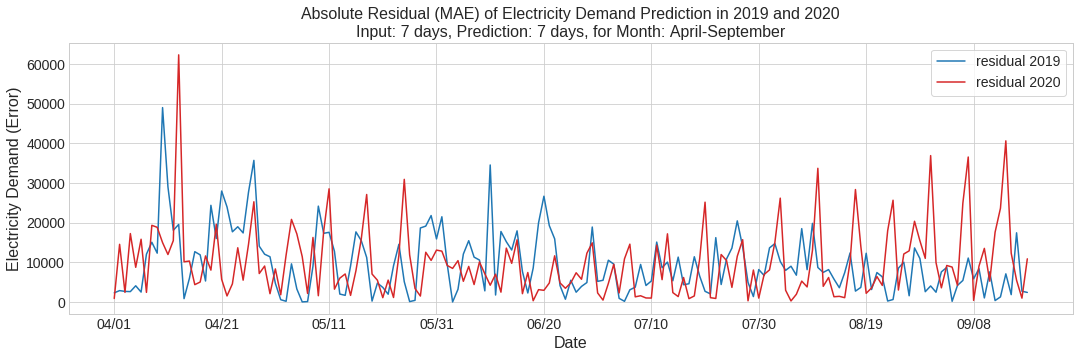

In [155]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

title = f'Absolute Residual (MAE) of Electricity Demand Prediction in 2019 and 2020\nInput: {window_len} days, Prediction: {forecast_len} days, for Month: April-September'
fig = plt.figure(figsize=(18,5))
ax = plt.axes()

plt.plot(new_day2019, new_res2019, color='tab:blue', label='residual 2019')      # Grayscale between 0 and 1
plt.plot(new_day2019, new_res2020, color='tab:red', label='residual 2020')      # Grayscale between 0 and 1
plt.title(title, fontsize=16)
plt.xlabel('Date',fontsize=16)
plt.ylabel('Electricity Demand (Error)', fontsize=16)
#plt.xticks(rotation=90)
ax.xaxis.set_major_locator(plt.MaxNLocator(12))
#ax.set_ylim(ymin=0)
#ax.set_ylim(ymax=0.4)
plt.legend(frameon=True, fontsize=14)
plt.tick_params(labelsize=14)
fig.savefig("residual_daily_forecast_demand(7to7)-final.pdf", bbox_inches='tight')

In [75]:
np.mean(new_res2019)

6603.284228801166

In [76]:
np.mean(new_res2020)

15066.1577997076

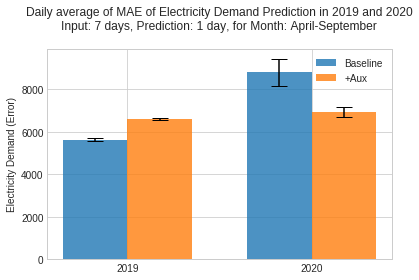

In [113]:
import matplotlib.pyplot as plt
import numpy as np


labels = ['2019', '2020']
baseline = [5623, 8802.6]
with_aux = [6598.7, 6934.7]

baseline_err = [69.1, 630.1]
with_aux_err = [57.9, 227.5]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, baseline, width, yerr=baseline_err, label='Baseline',capsize=8, alpha=0.8)
rects2 = ax.bar(x + width/2, with_aux, width, yerr=with_aux_err, label='+Aux',capsize=8, alpha=0.8)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Electricity Demand (Error)')
ax.set_title(f'Daily average of MAE of Electricity Demand Prediction in 2019 and 2020\nInput: 7 days, Prediction: 1 day, for Month: April-September\n')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


#autolabel(rects1)
#autolabel(rects2)

fig.tight_layout()


plt.show()
fig.savefig("MAE.pdf", bbox_inches='tight')

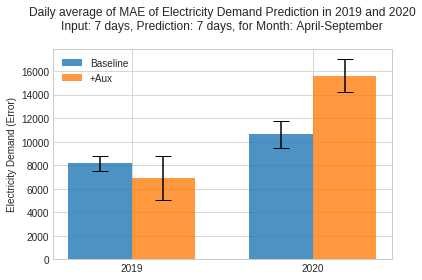

In [115]:
import matplotlib.pyplot as plt
import numpy as np


labels = ['2019', '2020']
baseline = [8158.9, 10625.6]
with_aux = [6928.6, 15615.3]

baseline_err = [619.5, 1125.1]
with_aux_err = [1872.3, 1418.7]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, baseline, width, yerr=baseline_err, label='Baseline',capsize=8, alpha=0.8)
rects2 = ax.bar(x + width/2, with_aux, width, yerr=with_aux_err, label='+Aux',capsize=8, alpha=0.8)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Electricity Demand (Error)')
ax.set_title(f'Daily average of MAE of Electricity Demand Prediction in 2019 and 2020\nInput: 7 days, Prediction: 7 days, for Month: April-September\n')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


#autolabel(rects1)
#autolabel(rects2)

fig.tight_layout()


plt.show()
fig.savefig("MAE-7days.pdf", bbox_inches='tight')